# Importing, Cleaning and Merging Data

In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For our modeling steps
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer


# from sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# For demonstrative purposes
from scipy.special import logit, expit

#Get rid of warning
import warnings
warnings.filterwarnings('ignore')

#pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn import set_config

#random forest
from sklearn.ensemble import RandomForestClassifier

#model evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report


In [3]:
#Loading Demographic Data
df = pd.read_csv("gen_data/DOE_Demographic.csv")
df_demo = df.loc[(df["Year"] == "2020-21") | (df["Year"] == "2021-22")]
df_demo["Year"].value_counts()


2021-22    1881
2020-21    1876
Name: Year, dtype: int64

In [4]:
#Schools that only show up once in the dataframe
df_grouped = df_demo.groupby("DBN")["Year"].count()
df_demo.reset_index(drop = True, inplace = True)
df_demo["Year"].value_counts()
df_demo["Year"] = df_demo["Year"].apply(lambda x: "2021" if x == "2020-21" else "2022")
df_demo["Year"].value_counts()

2022    1881
2021    1876
Name: Year, dtype: int64

In [5]:
#Loading attendance data
XLS = pd.ExcelFile("gen_data/attendance_data.xlsx")
df_att = pd.read_excel(XLS, "All Students")
df_att_year = df_att.loc[(df_att["Year"] == "2020-21") | (df_att["Year"] == "2021-22")]
df_att_all_grades = df_att_year[df_att_year["Grade"] == "All Grades"]
df_att_all_grades = df_att_all_grades.drop(columns = ["Grade", "Category", "# Contributing 10+ Total Days and 1+ Pres Day"], axis = 1)
df_att_all_grades["Year"] = df_att_all_grades["Year"].apply(lambda x: "2021" if x == "2020-21" else "2022")
df_att_no_s = df_att_all_grades.drop(df_att_all_grades[df_att_all_grades["% Chronically Absent"] == "s"].index)
df_att_no_s.reset_index(drop = True, inplace = True)




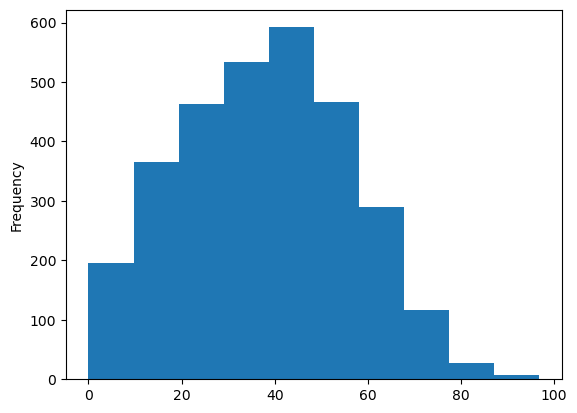

In [6]:
#Exploring Chronic absenteeism data
attendance = df_att_no_s['% Chronically Absent']
attendance.plot(kind = "hist");


In [7]:
#PE Space Data Set
PE_df = pd.read_csv("gen_data/PE_space.csv")
PE_df = PE_df.drop(columns = ["Borough", "Geographical  District", "Admin District", "Grade Level", "Bldg ID", "Ownership", "Room Number", "Room Function", "Shared with other schools?", "Space used for any other purpose beside PE", "Location 1"], axis = 1)
PE_df["Square Feet"] = PE_df["Square Feet"].apply(lambda x: x.replace(",", ""))
PE_df = PE_df.drop(PE_df[PE_df["Square Feet"] == "-"].index)
PE_df["Square Feet"] = PE_df["Square Feet"].astype(int)


In [8]:
#creating outdoor space df
PE_df_outdoor = PE_df[PE_df["Inside v outside"] == "Outside"]
PE_df_outdoor = PE_df_outdoor.groupby("ATS Code").sum()
PE_df_outdoor.reset_index(inplace = True)
PE_df_outdoor.rename(columns = {"Square Feet": "Outdoor Space (sqft)", "ATS Code": "DBN"}, inplace = True)

#creating indoor space df
PE_df_indoor = PE_df[PE_df["Inside v outside"] == "Inside"]
PE_df_indoor = PE_df_indoor.groupby("ATS Code").sum()
PE_df_indoor.reset_index(inplace = True)
PE_df_indoor.rename(columns = {"Square Feet": "Indoor Space (sqft)", "ATS Code": "DBN"}, inplace = True)
PE_df_indoor

#merging indoor and outdoor Dataframe
PE_df_merge = pd.merge(PE_df_indoor, PE_df_outdoor, on = ["DBN"])



In [9]:
#Survey Data for teachers 21
teacher_21 = pd.read_csv("survey_data/Teacher_Survey_2021.csv")
teacher_21 = teacher_21.drop(columns = ["Early Childhood Instruction"], axis =1)
teacher_21["DBN"] = teacher_21["Name"].apply(lambda x: x[0:6])
teacher_21["Name"] = teacher_21["Name"].apply(lambda x: x[9: ])
teacher_21["Year"] = "2021"
teacher_21 = teacher_21[['DBN', 'Name', "Year", 'Academic Press', 'Classroom Behavior',
       'Cultural Awareness and Inclusive Classroom Instruction', 'Guidance',
       'Innovation and Collective Responsibility', 'Instructional Leadership',
       'Outreach to Parents', 'Peer Collaboration', 'Program Coherence',
       'Quality of Professional Development', 'Quality of Student Discussion',
       'Safety', 'School Commitment', 'Social-Emotional',
       'Strong Core Instruction', 'Teacher Influence',
       'Teacher-Principal Trust', 'Teacher-Teacher Trust']]

#Survey Data for teachers 22
teacher_22 = pd.read_csv("survey_data/Teacher_Survey_2022.csv")
teacher_22["DBN"] = teacher_22["Name"].apply(lambda x: x[0:6])
teacher_22["Name"] = teacher_22["Name"].apply(lambda x: x[9: ])
teacher_22["Year"] = "2022"
teacher_22 = teacher_22[['DBN', 'Name', "Year", 'Academic Press', 'Classroom Behavior',
       'Cultural Awareness and Inclusive Classroom Instruction', 'Guidance',
       'Innovation and Collective Responsibility', 'Instructional Leadership',
       'Outreach to Parents', 'Peer Collaboration', 'Program Coherence',
       'Quality of Professional Development', 'Quality of Student Discussion',
       'Safety', 'School Commitment', 'Social-Emotional',
       'Strong Core Instruction', 'Teacher Influence',
       'Teacher-Principal Trust', 'Teacher-Teacher Trust']]


#Concating Teacher Survey Data
teacher_df = pd.concat([teacher_22, teacher_21])
teacher_df.sort_values("DBN", ascending = True, inplace = True)
teacher_df.reset_index(drop = True, inplace = True)
teacher_df.rename(columns = {'Name': 'School Name', 'Outreach to Parents': 'Outreach to Parents(T)'}, inplace = True)

#Survey Data for family 21
family_21 = pd.read_csv("survey_data/Families_Survey_2021.csv")
family_21["DBN"] = family_21["Name"].apply(lambda x: x[0:6])
family_21["Name"] = family_21["Name"].apply(lambda x: x[9: ])
family_21["Year"] = "2021"
family_21 = family_21[['DBN','Name', 'Year', 'Inclusive Leadership', 'Outreach to Parents',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust']]


#Survey Data for family 22
family_22 = pd.read_csv("survey_data/Families_Survey_2022.csv")
family_22["DBN"] = family_22["Name"].apply(lambda x: x[0:6])
family_22["Name"] = family_22["Name"].apply(lambda x: x[9: ])
family_22["Year"] = "2022"
family_22 = family_22[['DBN','Name', 'Year', 'Inclusive Leadership', 'Outreach to Parents',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust']]

#Concating family survey data
family_df = pd.concat([family_22, family_21])
family_df.sort_values("DBN", ascending = True, inplace = True)
family_df.reset_index(drop = True, inplace = True)
family_df.rename(columns = {'Name': 'School Name', 'Outreach to Parents': 'Outreach to Parents(F)'}, inplace = True)
family_df

,DBN,School Name,Year,Inclusive Leadership,Outreach to Parents(F),Parent Involvement in School,Parent-Principal Trust,Parent-Teacher Trust
0,01M015,P.S. 015 Roberto Clemente,2022,90.0,93.0,86.0,92.0,93.0
1,01M015,P.S. 015 Roberto Clemente,2021,97.0,98.0,87.0,98.0,96.0
2,01M019,P.S. 019 Asher Levy,2022,72.0,91.0,89.0,71.0,86.0
3,01M019,P.S. 019 Asher Levy,2021,96.0,98.0,94.0,97.0,97.0
4,01M020,P.S. 020 Anna Silver,2022,98.0,97.0,91.0,97.0,98.0
...,...,...,...,...,...,...,...,...
5371,Z149 -,E RICHMOND PRE-K CENTER AT 375 TOMPKINS AVENUE,2022,100.0,97.0,88.0,95.0,99.0
5372,Z150 -,E RICHMOND PRE-K CENTER AT 2389 RICHMOND AVE,2022,93.0,96.0,94.0,89.0,97.0
5373,Z151 -,E RICHMOND PRE-K CENTER AT 1800 RICHMOND TERRACE,2022,100.0,100.0,95.0,100.0,100.0
5374,Z152 -,RDEN OF LEARNING AND DISCOVERY PRE-K CENTER AT...,2022,100.0,100.0,100.0,100.0,100.0


<AxesSubplot: ylabel='Frequency'>

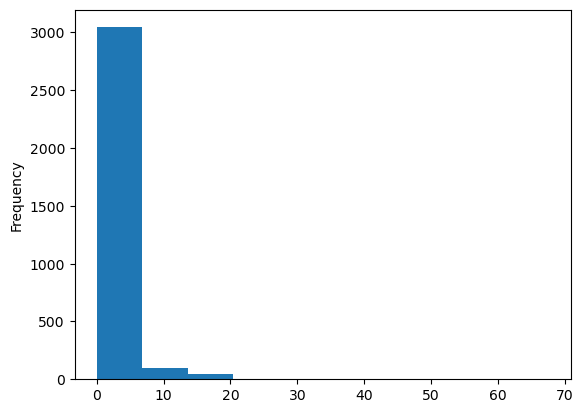

In [81]:
#Guidance Counselor and Social Work Data
df_guidance_2021 = pd.read_csv("gen_data/guidance_21.csv")
df_guidance_2022 = pd.read_csv("gen_data/guidance_22.csv")

#Drop Nan Values
df_guidance_2021.dropna(inplace = True)
df_guidance_2022.dropna(inplace = True)

#adding year column
df_guidance_2021["Year"] = "2021"
df_guidance_2022["Year"] = "2022"

#dropping columns
df_guidance_2021 = df_guidance_2021[["DBN", "Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)", "Year"]]
df_guidance_2021.rename(columns = {"Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)": "Number of Counselors"}, inplace = True)
df_guidance_2022 = df_guidance_2022[["DBN", "Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)", "Year"]]
df_guidance_2022.rename(columns = {"Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)": "Number of Counselors"}, inplace = True)

counselor_concat = pd.concat([df_guidance_2022, df_guidance_2021])

counselor_concat.sort_values("DBN", ascending = True, inplace = True)

counselor_concat.loc[counselor_concat["DBN"] == '04M310', 'Number of Counselors'] = 6.0

counselor_concat.loc[counselor_concat["Number of Counselors"] == 'Has counseling service (outside provider)', 'Number of Counselors'] = 1.0

counselor_concat.loc[counselor_concat["Number of Counselors"] == '5 school psychologists providing counseling services', 'Number of Counselors'] = 5.0

counselor_concat.loc[counselor_concat["Number of Counselors"] == '4 full-time school psychologists providing counseling services', 'Number of Counselors'] = 4.0

counselor_concat.loc[counselor_concat["Number of Counselors"] == '3 full-time school psychologists providing counseling services', 'Number of Counselors'] = 3.0

counselor_concat.loc[counselor_concat["Number of Counselors"] == '2 full-time school psychologists providing counseling services', 'Number of Counselors'] = 2.0

counselor_concat = counselor_concat.drop(counselor_concat[counselor_concat["Number of Counselors"] == 'In progress (interviewing)'].index)

counselor_concat = counselor_concat.drop(counselor_concat[counselor_concat["Number of Counselors"] == 'New school and small enrollment'].index)

counselor_concat["Number of Counselors"] = counselor_concat["Number of Counselors"].astype(float)



In [80]:
#Merging all Data Sets
df_merge_1 = pd.merge(df_demo, df_att_no_s, on = ['DBN', 'School Name', 'Year'])
df_merge_2 = pd.merge(df_merge_1, PE_df_merge, on = ['DBN'])
df_merge_3 = pd.merge(df_merge_2, teacher_df, on = ['DBN', 'School Name', 'Year'])
df_merge_4 = pd.merge(df_merge_3, family_df, on = ['DBN', 'School Name', 'Year'])
df_final = pd.merge(df_merge_4, counselor_concat, on = ['DBN', 'Year'])

df_final


,DBN,School Name,Year,Total Enrollment,Grade 3K,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,...,Strong Core Instruction,Teacher Influence,Teacher-Principal Trust,Teacher-Teacher Trust,Inclusive Leadership,Outreach to Parents(F),Parent Involvement in School,Parent-Principal Trust,Parent-Teacher Trust,Number of Counselors
0,01M015,P.S. 015 Roberto Clemente,2022,179,0,15,30,26,24,22,...,98.0,86.0,93.0,96.0,90.0,93.0,86.0,92.0,93.0,1.6
1,01M019,P.S. 019 Asher Levy,2021,212,0,13,23,25,27,38,...,99.0,92.0,95.0,95.0,96.0,98.0,94.0,97.0,97.0,2.0
2,01M019,P.S. 019 Asher Levy,2022,176,9,7,22,20,22,23,...,98.0,73.0,93.0,99.0,72.0,91.0,89.0,71.0,86.0,1.4
3,01M020,P.S. 020 Anna Silver,2021,412,0,37,58,52,60,66,...,92.0,95.0,89.0,91.0,96.0,95.0,90.0,94.0,95.0,2.6
4,01M020,P.S. 020 Anna Silver,2022,351,0,42,52,50,42,48,...,99.0,85.0,95.0,91.0,98.0,97.0,91.0,97.0,98.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,75X352,The Vida Bogart School for All Children,2022,499,2,1,58,39,75,104,...,91.0,70.0,86.0,88.0,96.0,97.0,88.0,97.0,98.0,2.0
1885,75X721,P.S. X721 - Stephen McSweeney School,2021,589,0,0,0,0,0,0,...,92.0,80.0,89.0,87.0,88.0,88.0,66.0,89.0,90.0,4.6
1886,75X721,P.S. X721 - Stephen McSweeney School,2022,547,0,0,0,0,0,0,...,97.0,69.0,88.0,90.0,95.0,95.0,86.0,96.0,95.0,5.0
1887,75X754,J. M. Rapport School Career Development,2021,502,0,0,0,0,0,0,...,82.0,90.0,89.0,95.0,100.0,99.0,93.0,100.0,100.0,7.0


In [82]:
#Additional Data Cleaning
df_final['% Poverty'] = df_final['% Poverty'].apply(lambda x: "95.0" if x == 'Above 95%' else x.strip("%"))
df_final['Economic Need Index'] = df_final['Economic Need Index'].apply(lambda x: "95.0" if x == 'Above 95%' else x.strip("%"))
df_final['% Chronically Absent'] = df_final['% Chronically Absent'].apply(lambda x: "95.0" if x == 'Above 95%' else x)
df_final = df_final.drop(columns = ["# Poverty", '# Days Absent', '# Days Present', '% Attendance', '# Chronically Absent', '# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial', '# Native American', '# White', '# Missing Race/Ethnicity Data', '# Students with Disabilities', '# English Language Learners', '# Poverty', '# Total Days'], axis = 1)
df_final = df_final.astype({'% Poverty':  float, 'Economic Need Index': float, '% Chronically Absent':float})

In [83]:
#Creating Borough and School District Columns
df_final["Borough"] = df_final["DBN"].apply(lambda x: x[2:3])
df_final["School District"] = df_final["DBN"].apply(lambda x: x[0:2])
df_final.drop(columns = ["DBN"], axis = 1, inplace = True)

In [84]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1888
Data columns (total 61 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   School Name                                             1889 non-null   object 
 1   Year                                                    1889 non-null   object 
 2   Total Enrollment                                        1889 non-null   int64  
 3   Grade 3K                                                1889 non-null   int64  
 4   Grade PK (Half Day & Full Day)                          1889 non-null   int64  
 5   Grade K                                                 1889 non-null   int64  
 6   Grade 1                                                 1889 non-null   int64  
 7   Grade 2                                                 1889 non-null   int64  
 8   Grade 3                               

In [85]:
#Calculating per capita
df_final["Indoor Space Per Capita"] = df_final['Indoor Space (sqft)']/df_final['Total Enrollment']
df_final["Outdoor Space Per Capita"] = df_final['Outdoor Space (sqft)']/df_final['Total Enrollment']

In [86]:
#dropping outdoor and indoor space
df_final.drop(columns = ['Indoor Space (sqft)', 'Outdoor Space (sqft)'], axis = 1, inplace = True)

In [87]:
#Filling Missing Data
df_final.loc[df_final['School Name'] == 'P.S. 149 Sojourner Truth', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'Central Park East I', 'Strong Core Instruction'] = 92.0
df_final.loc[df_final['School Name'] == 'Hamilton Grange Middle School', 'Strong Core Instruction'] = 92.0
df_final.loc[df_final['School Name'] == 'City College Academy of the Arts', 'Strong Core Instruction'] = 96.0
df_final.loc[df_final['School Name'] == 'M.S. 324 - Patria Mirabal', 'Strong Core Instruction'] = 99.0
df_final.loc[df_final['School Name'] == "Women's Academy of Excellence", 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Bronx Health Sciences High School', 'Strong Core Instruction'] = 89.0
df_final.loc[df_final['School Name'] == 'P.S. 044 Marcus Garvey', 'Strong Core Instruction'] = 97.0
df_final.loc[df_final['School Name'] == 'M.S. 113 Ronald Edmonds Learning Center', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'M.S. K266 - Park Place Community Middle School', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'The Urban Assembly Unison School', 'Strong Core Instruction'] = 93.0
df_final.loc[df_final['School Name'] == 'Fort Greene Preparatory Academy', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Whitelaw Reid Academy of Arts and Business', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'I.S. 340', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Elijah Stroud Middle School', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'Ronald Edmonds Learning Center II', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'P.S. 268 Emma Lazarus', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'P.S. 279 Herman Schreiber', 'Strong Core Instruction'] = 94.0
df_final.loc[df_final['School Name'] == 'P.S. 202 Ernest S. Jenkyns', 'Strong Core Instruction'] = 93.0
df_final.loc[df_final['School Name'] == 'International High School at Lafayette', 'Strong Core Instruction'] = 95.0



In [88]:
#dropping NaN values
df_final = df_final.dropna()

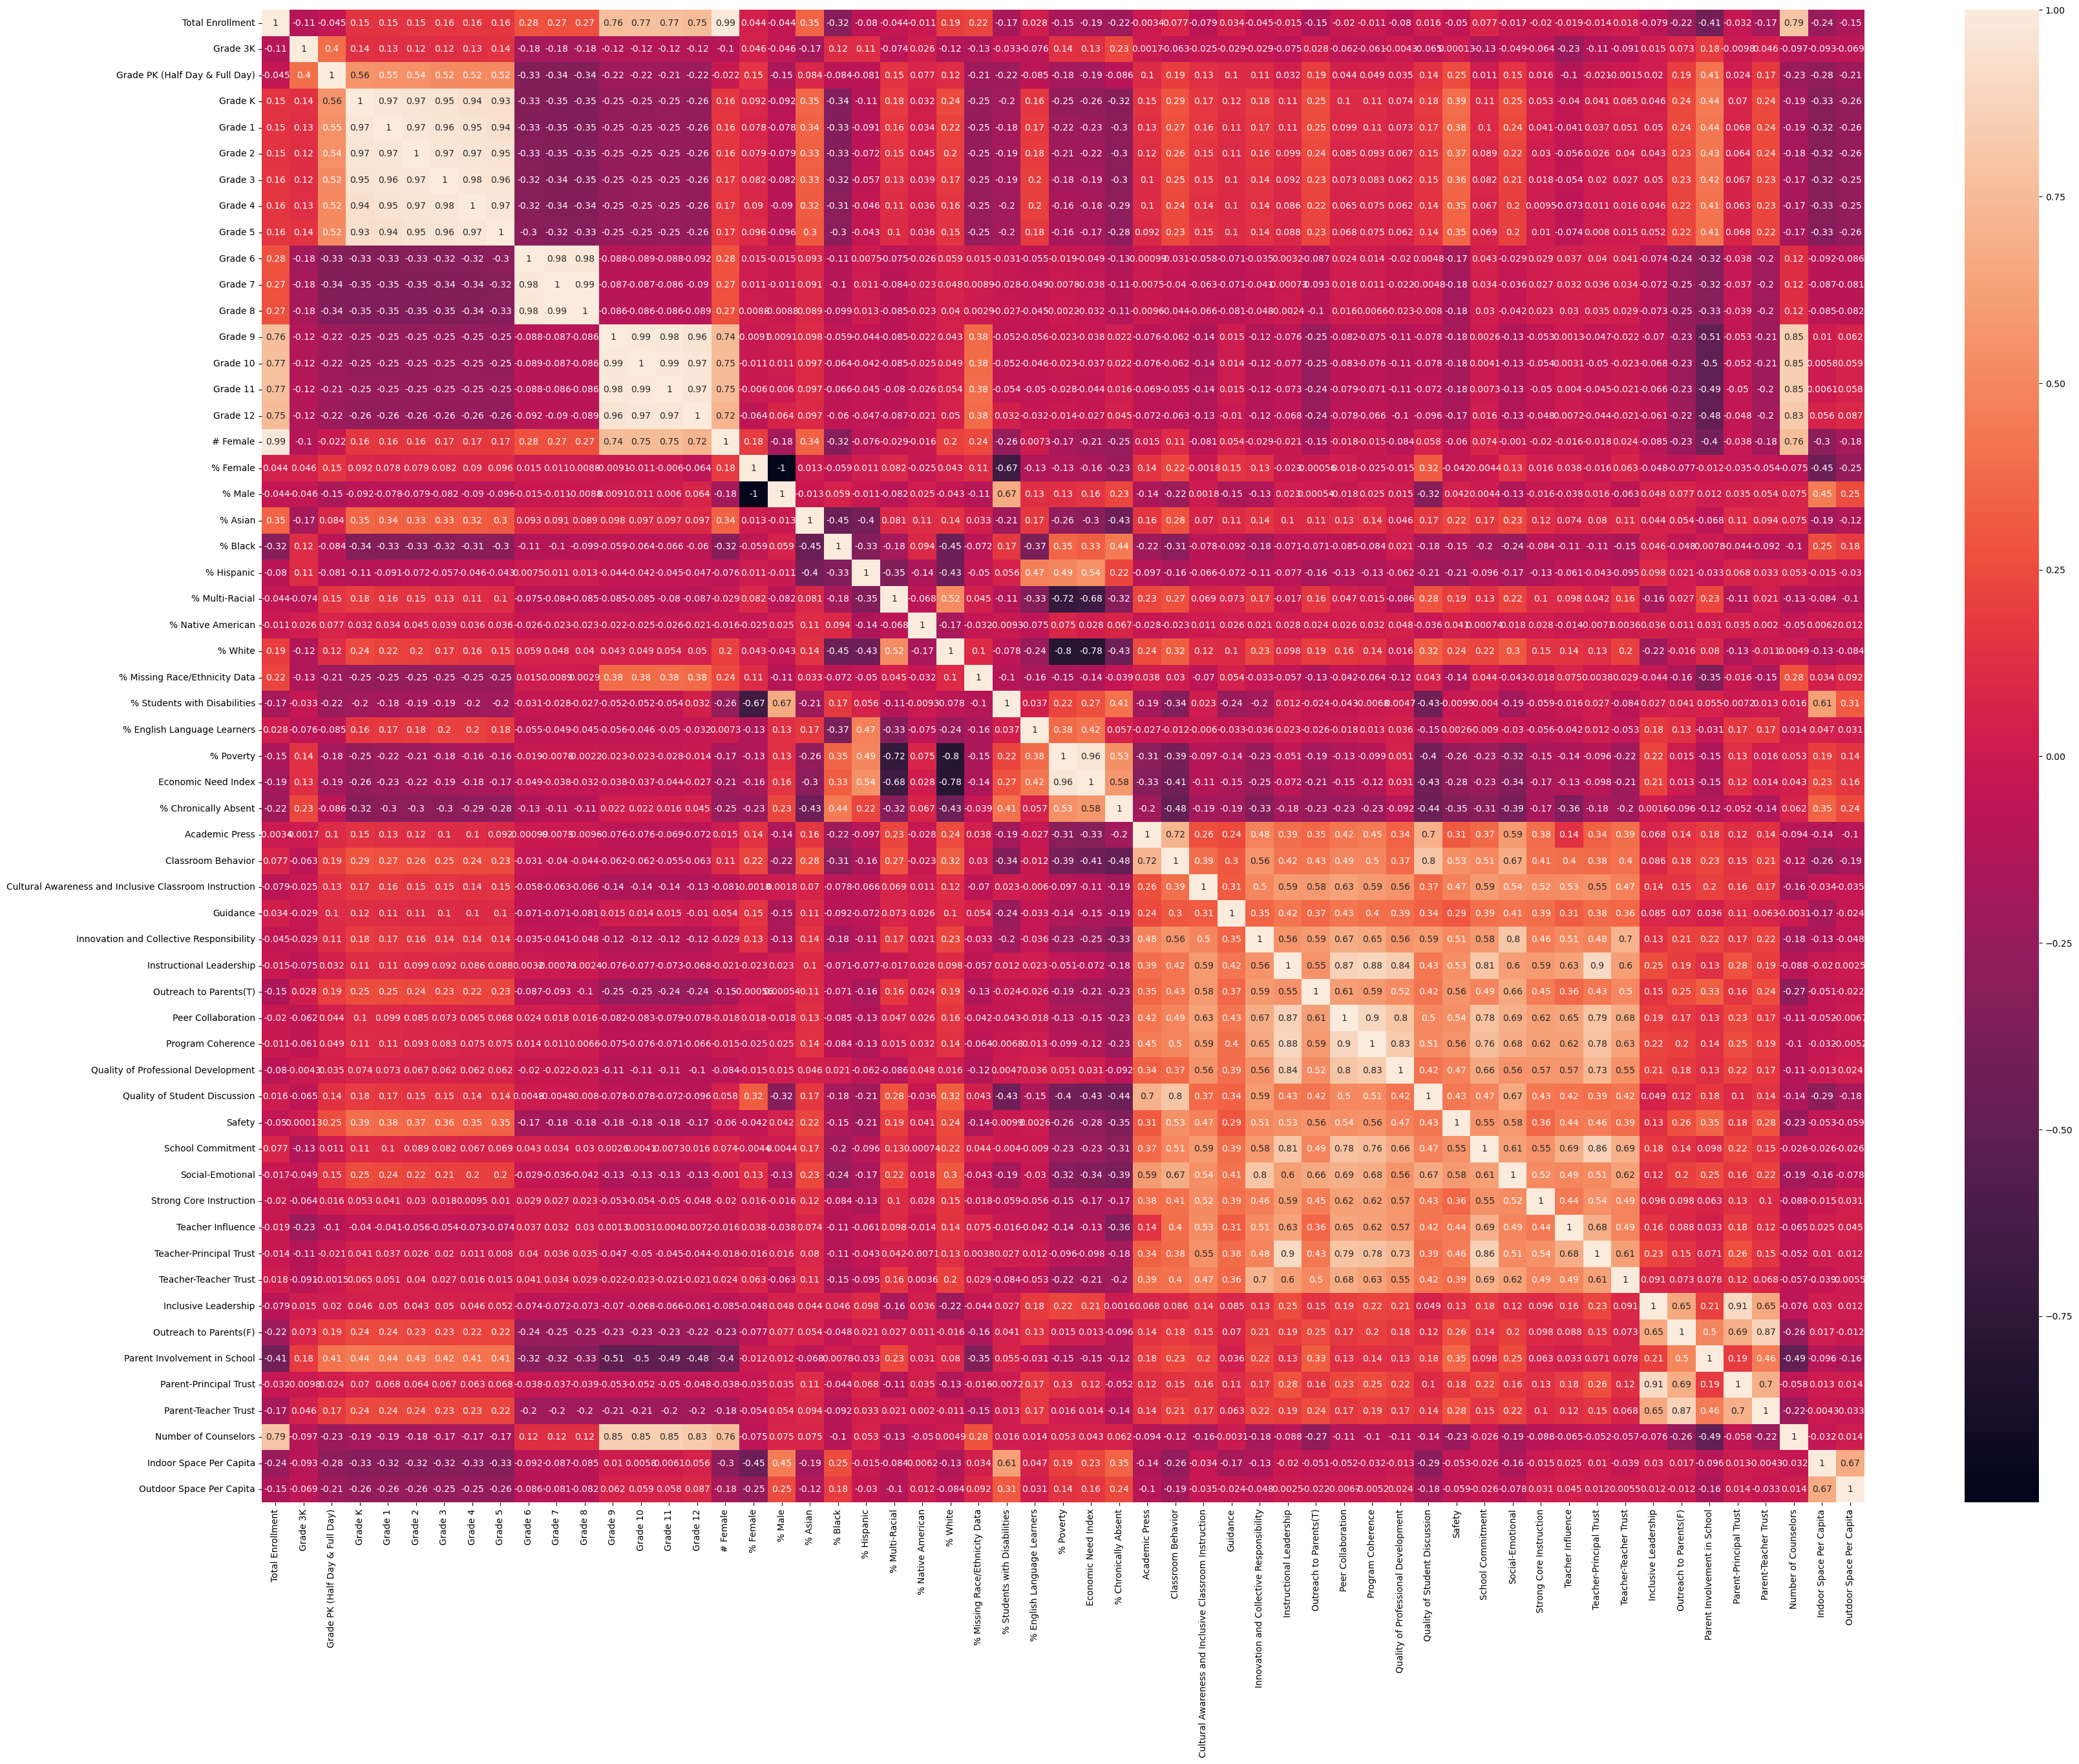

In [89]:
plt.figure(figsize=(40, 30))
sns.heatmap(df_final.corr(), annot = True)
plt.show();

# Train Test Split

In [31]:
#Baseline logistic regression
#QUESTION: talk to brendan about this value tomorrow. Is it okay that I do not have even data between year?
y = df_final['% Chronically Absent']
y = y.apply(lambda x: 0 if x < y.quantile(q = 0.75) else 1)
X = df_final.drop(columns = ['% Chronically Absent'], axis = 1)

# Perform train-test split with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)



# Creating my Pipeline

In [ ]:
#KNN and Stacking